In [1]:
import pandas as pd

## Load SC windows

In [6]:
sc_filtered = pd.read_csv('shuffled_eclips/rbfox2_sc_agg_score_0.999_poisson_boost_100_density.bed',
           sep='\t', names=['chrom', 'start', 'end', 'ids', 'geneid', 'strand'])

In [7]:
sc_filtered.head()

,chrom,start,end,ids,geneid,strand
0,chr1,228134,228269,"chr1:228134-228185,chr1:228204-228255,chr1:228...",ENSG00000228463.4,-
1,chr1,1169044,1169145,"chr1:1169044-1169095,chr1:1169094-1169145",ENSG00000176022.3,+
2,chr1,1337361,1337456,"chr1:1337361-1337412,chr1:1337405-1337456",ENSG00000242485.1,-
3,chr1,1717397,1717580,"chr1:1717397-1717448,chr1:1717441-1717492,chr1...",ENSG00000078369.13,-
4,chr1,6245282,6245364,"chr1:6245282-6245333,chr1:6245291-6245342,chr1...",ENSG00000116251.5,-


In [8]:
bulk_filtered = pd.read_csv('shuffled_eclips/c_terminus_score_0.999_poisson_boost_100_density.bed',
           sep='\t', names=['chrom', 'start', 'end', 'ids', 'geneid', 'strand'])

In [9]:
bulk_filtered.head()

,chrom,start,end,ids,geneid,strand
0,chr1,1337361,1337456,"chr1:1337361-1337412,chr1:1337405-1337456",ENSG00000242485.1,-
1,chr1,1716738,1716999,"chr1:1716738-1716789,chr1:1716782-1716833,chr1...",ENSG00000078369.13,-
2,chr1,1717247,1717677,"chr1:1717247-1717298,chr1:1717344-1717395,chr1...",ENSG00000078369.13,-
3,chr1,2239874,2240088,"chr1:2239874-2239925,chr1:2239905-2239956,chr1...",ENSG00000157933.9,+
4,chr1,3763339,3763436,"chr1:3763339-3763390,chr1:3763385-3763436",ENSG00000116198.8,-


# Target-level overlap

In [14]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

def target_level(eclip1_df, eclip2_df, eclip1_label="", eclip2_label=""):
    genes_covered_by_eclip1 = set([i.split('.')[0] for i in eclip1_df.geneid])
    genes_covered_by_eclip2 = set([i.split('.')[0] for i in eclip2_df.geneid])
    
    eclip1_genes_covered_by_eclip2 = genes_covered_by_eclip1.intersection(genes_covered_by_eclip2)
    
    fraction_of_eclip1_genes_covered_by_eclip2 = len(eclip1_genes_covered_by_eclip2) / len(genes_covered_by_eclip1)
    
    fraction_of_eclip2_genes_covered_by_eclip1 = len(eclip1_genes_covered_by_eclip2) / len(genes_covered_by_eclip2)
    
    
    # make venn diagrams
    plt.figure(figsize=(10,5))
    venn2([genes_covered_by_eclip1, genes_covered_by_eclip2],
          set_labels = ('{} of {} targets are {} targets'.format(round(fraction_of_eclip1_genes_covered_by_eclip2, 3), eclip1_label, eclip2_label),
                        '{} of {} targets are {} targets'.format(round(fraction_of_eclip2_genes_covered_by_eclip1, 3), eclip2_label, eclip1_label)))
              
    plt.title("Fraction of gene-level targets supported between bulk and aggregate single-cell assays")
    plt.legend([eclip1_label, eclip2_label])

    if eclip1_label != "" and eclip2_label != "":
        plt.savefig("new_svgs/target_level_{}_{}.svg".format(eclip1_label.replace(" ", "_"),
                                                     eclip2_label.replace(" ", "_")
                                                    ))
    plt.show()

    print('{} count'.format(eclip1_label), len(genes_covered_by_eclip1))
    print('{} count'.format(eclip2_label), len(genes_covered_by_eclip2))
    #return fraction_of_eclip_genes_covered_by_stamp, fraction_of_stamp_genes_covered_by_eclip, eclip_genes_not_covered_by_stamp, \
#genes_covered_by_stamp, genes_covered_by_eclip

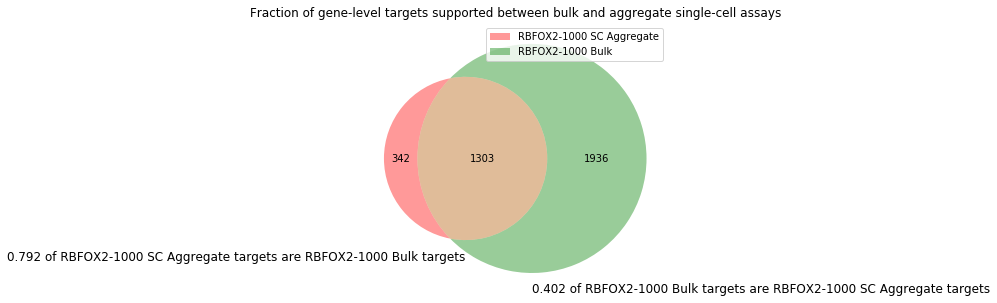

RBFOX2-1000 SC Aggregate count 1645
RBFOX2-1000 Bulk count 3239


In [15]:
target_level(sc_filtered, bulk_filtered, "RBFOX2-1000 SC Aggregate", "RBFOX2-1000 Bulk")

In [26]:
len(sc_filtered)

1903

In [17]:
len(sc_filtered.geneid.unique())

1649

In [18]:
len(bulk_filtered.geneid.unique())

3241

# Target level

In [101]:
import pybedtools


paddings = [0, 50, 100, 150, 200, 250, 300, 350, 400]

fractions_sc_overlapped = []
fractions_bulk_overlapped = []

for padding in paddings:
    print('For {} padding on either side or STAMP regions:'.format(padding))
    sc_bedtool = pybedtools.BedTool.from_dataframe(sc_filtered).slop(genome="hg19", b=padding)
    bulk_bedtool = pybedtools.BedTool.from_dataframe(bulk_filtered).slop(genome="hg19", b=padding)

    intersection = sc_bedtool.intersect(bulk_bedtool, loj=True, wa=True, wb=True, s=True).to_dataframe(
        names = ['chrom_sc', 'start_sc', 'end_sc', 'name_sc', 'geneid_sc', 'strand_sc',
                 'chrom', 'start', 'end', 'name', 'geneid', 'strand'
                ]
    )
    print('\t{} out of {} SC regions overlap with bulk regions'.format(
        len(intersection[intersection.chrom != '.'].drop_duplicates(['chrom_sc', 'start_sc', 'end_sc'])),
        len(intersection.drop_duplicates(['chrom_sc', 'start_sc', 'end_sc']
    ))))
    fraction_sc_overlapped = len(intersection[intersection.chrom != '.'].drop_duplicates(['chrom_sc', 'start_sc', 'end_sc']))/\
    len(intersection.drop_duplicates(['chrom_sc', 'start_sc', 'end_sc']))

    print('\t\t', fraction_sc_overlapped)
    fractions_sc_overlapped.append(fraction_sc_overlapped)

    intersection_opposite = bulk_bedtool.intersect(sc_bedtool, loj=True, wa=True, wb=True).to_dataframe(
        names = [
                 'chrom', 'start', 'end', 'name', 'geneid', 'strand',
            'chrom_sc', 'start_sc', 'end_sc', 'name_sc', 'geneid_sc', 'strand_sc'
                ]
    )
    print('\t{} out of {} bulk regions overlap with SC regions'.format(
        len(intersection_opposite[intersection_opposite.chrom_sc != '.'].drop_duplicates(['chrom', 'start', 'end'])),
        len(intersection_opposite.drop_duplicates(['chrom', 'start', 'end']
    ))))
    fraction_bulk_overlapped = len(intersection_opposite[intersection_opposite.chrom_sc != '.'].drop_duplicates(['chrom', 'start', 'end']))/\
    len(intersection_opposite.drop_duplicates(['chrom', 'start', 'end']))
    print('\t\t', fraction_bulk_overlapped)
    fractions_bulk_overlapped.append(fraction_bulk_overlapped)

For 0 padding on either side or STAMP regions:
	1142 out of 1903 SC regions overlap with bulk regions
		 0.6001050972149238
	1162 out of 5044 bulk regions overlap with SC regions
		 0.2303727200634417
For 50 padding on either side or STAMP regions:
	1243 out of 1903 SC regions overlap with bulk regions
		 0.653179190751445
	1362 out of 5044 bulk regions overlap with SC regions
		 0.2700237906423473
For 100 padding on either side or STAMP regions:
	1328 out of 1903 SC regions overlap with bulk regions
		 0.697845507094062
	1519 out of 5044 bulk regions overlap with SC regions
		 0.30114988104678825
For 150 padding on either side or STAMP regions:
	1366 out of 1903 SC regions overlap with bulk regions
		 0.7178139779295849
	1634 out of 5044 bulk regions overlap with SC regions
		 0.323949246629659
For 200 padding on either side or STAMP regions:
	1395 out of 1903 SC regions overlap with bulk regions
		 0.7330530740935365
	1731 out of 5044 bulk regions overlap with SC regions
		 0.3431800

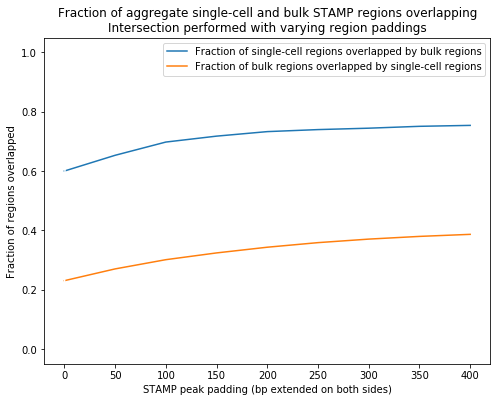

In [103]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(paddings, fractions_sc_overlapped)
plt.plot(paddings, fractions_bulk_overlapped)
plt.legend(['Fraction of single-cell regions overlapped by bulk regions',
            'Fraction of bulk regions overlapped by single-cell regions'
           ])
plt.xlabel("STAMP peak padding (bp extended on both sides)")
plt.ylabel("Fraction of regions overlapped")
plt.title("Fraction of aggregate single-cell and bulk STAMP regions overlapping\nIntersection performed with varying region paddings")
plt.plot([0, 0], c='w')
plt.plot([0, 1], c='w')
plt.savefig('new_svgs/region_level_RBFOX2-1000_SC_Aggregate_RBFOX2-1000_Bulk.svg')